# Meal Planning
Scott Jenkins, January 2023

Motivation: 

- I enjoy cooking, but I don't enjoy the process of deciding what to cook, planning the food shop etc.
- I want to automate these decisions, so that I can focus on the cooking!

This notebook contains attempts to do this:
- Markov model: choose meals based only on the previous meal to avoid having the same protein or carbs multiple nights in a row.

### Load Libraries

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import random
import datetime as dt

In [2]:
import yagmail                                      # used to send emails
python_app_password = 'insert your password here'   # created in gmail to allow sign in from external apps.

### Load Data

In [3]:
meal_df = pd.read_excel('meals.xlsx',sheet_name='meal_df')
print('There are',len(meal_df),'meals to choose from.')
meal_df.head()

There are 22 meals to choose from.


,meal_id,meal_name,protein,protein_id,carbs,carb_id,provides_lunch,ingredients
0,1,chicken gravy pie,chicken,1,potato,1,1,"chicken,pastry,potatoes,leeks,onions,carrots,p..."
1,2,curry,chicken,1,rice,2,1,"chicken,rice,spinach,onions,garlic,curry sauce..."
2,3,creamy chicken pasta,chicken,1,pasta,3,1,"chicken,pasta,crème fraiche,peas,broccoli,lemo..."
3,4,sausage pasta bake,sausage,2,pasta,3,1,"sausages,pasta,tinned tomatoes,mushrooms,chees..."
4,5,bangers and mash,sausage,2,potato,1,1,"sausages,potatoes,broccoli,gravy granules,onions"


### Set up Graph of permitted meal pairs

Nodes will be numbered by their meal id

Example Legal Edges: [(1, 4), (1, 6), (1, 7), (1, 8), (1, 9), (1, 12), (1, 13)]


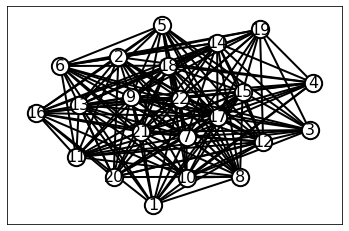

In [4]:
G = nx.Graph()

legal_edges = []
for i in range(len(meal_df)):
    for j in range(len(meal_df)):
        if j > i:
            # if same 
            if ((meal_df['protein_id'][i] != meal_df['protein_id'][j]) and (meal_df['carb_id'][i] != meal_df['carb_id'][j])):
                # print('Legal Sequence: ',(i+1,j+1))
                legal_edges.append((i+1,j+1))
                G.add_edge(i+1, j+1)
                
print('Example Legal Edges:', legal_edges[:7])

options = {
    "font_size": 16,
    "node_size": 300,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 2,
    "width": 2,
}
nx.draw_networkx(G, **options)

In [5]:
## Testing a meal planner

# meals_to_plan = 10

# meal_list = []

# current_node = np.random.randint(len(meal_df)) # pick a starting node
# # print('Start Node:', current_node)
# meal_list.append(current_node) # append to meal list

# while len(meal_list) < meals_to_plan:
#     next_node_list = [n for n in G.neighbors(current_node)] # the neighbours of current node in G
#     next_node = random.choice(next_node_list)               # select next node randomly from list of neighbours
#     if meal_list.count(next_node) == 0:                      # if not already having this meal, then append it to meal_list
#         meal_list.append(next_node)                         
#     current_node = next_node                                # set as current node
    
# meal_list

# meal_plan = meal_df[meal_df['meal_id']==meal_list[0]].reset_index(drop=True)

# for i in meal_list[1:]:
#     meal_plan = pd.concat([meal_plan,meal_df[meal_df['meal_id']==i]],axis=0)

# meal_plan = meal_plan.reset_index(drop=True)
# meal_plan

## Meal Planning

In [6]:
meals_to_plan = 5  # The number of days ahead (including tonight) that you'd like to plan

In [7]:
dates_df = pd.DataFrame()
dates_df['date'] = pd.date_range(start=dt.date.today(), periods=meals_to_plan, freq='d')
dates_df['weekday'] = pd.date_range(start=dt.date.today(), periods=meals_to_plan, freq='d').strftime('%A')
dates_df['need_lunch'] = np.where(dates_df['weekday'].isin(['Friday','Saturday']), 0, 1)

meal_list = []
value = ''

# Pick the first meal in the plan

while value != '1':   ## Keep suggesting meals, until I agree what I want for dinner tonight!
    current_node = np.random.randint(1,len(meal_df)) # pick a random starting node
    value = input(f"Meal Planner suggests {meal_df.iloc[current_node-1]['meal_name']}. Press 1 if you are happy with this selection: ")

print(current_node)
meal_list.append(current_node) # append first meal to meal list
my_meals = meal_df[meal_df['meal_id']==current_node]
print('Added to Meal Plan!')
i = 1

while i < len(dates_df):
    next_node_list = [n for n in G.neighbors(current_node)] # the neighbours of current node in G
    next_node_list = [k for k in next_node_list if k not in meal_list] # remove meals if already on meal list
    next_node = random.choice(next_node_list)               # select next node randomly from remaining neighbours
    value = input(f"Meal Planner suggests {meal_df.iloc[next_node-1]['meal_name']}. Press 1 if you are happy with this selection: ")
    if value == '1':
        meal_list.append(next_node) # append to meal list
        my_meals = pd.concat([my_meals,meal_df[meal_df['meal_id']==next_node]],axis=0)
        print('Added to Meal Plan!')                
        current_node = next_node  # set as current node
        i += 1
    else:
        print("Too Bad! I'll try again!")
        current_node = current_node
    
print('Meal List:',meal_list)

planner_df = pd.concat([dates_df,my_meals.reset_index(drop=True)],axis=1).head(meals_to_plan)
planner_df

Meal Planner suggests sausage pasta bake. Press 1 if you are happy with this selection: 1
4
Added to Meal Plan!
Meal Planner suggests risotto. Press 1 if you are happy with this selection: 1
Added to Meal Plan!
Meal Planner suggests bangers and mash. Press 1 if you are happy with this selection: 1
Added to Meal Plan!
Meal Planner suggests curry. Press 1 if you are happy with this selection: 1
Added to Meal Plan!
Meal Planner suggests mac n cheese. Press 1 if you are happy with this selection: 1
Added to Meal Plan!
Meal List: [4, 15, 5, 2, 6]


,date,weekday,need_lunch,meal_id,meal_name,protein,protein_id,carbs,carb_id,provides_lunch,ingredients
0,2023-02-10,Friday,0,4,sausage pasta bake,sausage,2,pasta,3,1,"sausages,pasta,tinned tomatoes,mushrooms,chees..."
1,2023-02-11,Saturday,0,15,risotto,bacon,3,rice,2,1,"bacon,risotto rice,mushrooms,peppers,broccoli,..."
2,2023-02-12,Sunday,1,5,bangers and mash,sausage,2,potato,1,1,"sausages,potatoes,broccoli,gravy granules,onions"
3,2023-02-13,Monday,1,2,curry,chicken,1,rice,2,1,"chicken,rice,spinach,onions,garlic,curry sauce..."
4,2023-02-14,Tuesday,1,6,mac n cheese,bacon,3,pasta,3,1,"pasta,bacon,cheese,breadcrumbs,flour,garlic bread"


## Now Make the Shopping List

In [8]:
ingredients = pd.read_excel('meals.xlsx',sheet_name='ingredients')
ingredients.head()

print('Here is a list of common things you buy. Press 1 if you want me to add it to your shopping list, press 0 if not...')

# initialise empty shopping list
shopping_list = []

## Opportunity to add commonly bought items to the list

common = ['milk','cereal','orange juice','bread','bananas','apples','eggs','cereal bars']

for i in common:
    value = input(f'{i}?  ')
    if value == '1':
        shopping_list.append(i) # don't need to append the value, need to append the item! 
print('Great, thanks!')

# Add the ingredients needed for the selected meals
meal_shopping_list = []
for i in range(len(planner_df)):
    meal_shopping_list = np.concatenate((meal_shopping_list,planner_df['ingredients'][i].split(',') ), axis=0)

shopping_list.extend(meal_shopping_list)
final_list = [*set(shopping_list)]
final_list.sort()

print(f'Shopping List Complete, {len(final_list)} items on your shopping list this week')


for i in final_list:
    print(i, end=', ')

Here is a list of common things you buy. Press 1 if you want me to add it to your shopping list, press 0 if not...
milk?  1
cereal?  1
orange juice?  1
bread?  1
bananas?  1
apples?  1
eggs?  1
cereal bars?  1
Great, thanks!
Shopping List Complete, 30 items on your shopping list this week
apples, bacon, bananas, bread, breadcrumbs, broccoli, cereal, cereal bars, cheese, chicken, curry sauce jar, eggs, flour, garlic, garlic bread, gravy granules, milk, mushrooms, naan bread, onions, orange juice, pasta, peppers, potatoes, rice, risotto rice, sausages, spinach, stock, tinned tomatoes, 

In [11]:
# Option to remove items from the list before finalised...
remove = [] 

# remove = ['lemon juice','peas','wraps']

for item in remove:
    final_list.remove(item)

In [12]:
need_to_buy = ingredients[ingredients['food_name'].isin(final_list)].sort_values('department_id')
need_to_buy.head()

food_df = need_to_buy[['department_name','food_name']]
food_df

,department_name,food_name
0,fruit_veg,apples
32,fruit_veg,mushrooms
21,fruit_veg,garlic
40,fruit_veg,peppers
41,fruit_veg,potatoes
34,fruit_veg,onions
6,fruit_veg,broccoli
51,fruit_veg,spinach
2,fruit_veg,bananas
13,meat,chicken


In [13]:
# for i in need_to_buy['department_name'].unique():
#     print(str.upper(i))
#     dept_list = list(need_to_buy[need_to_buy['department_name']==i]['food_name'])                
#     print(dept_list)

## Email  the meal plan and shopping list

Uses yagmail, with password created in gmail

In [14]:
# This block of code sends emails!
user = "email address you'd like to send the email from"
app_password = python_app_password
date_string = dt.date.today().strftime('%A %d %B %Y')

recipients = ["email addresses you'd like to send the email to"]
subject = f'Meal Plan: {date_string}'
content = ['This email was produced and emailed entirely in python :)', 
           ' ',
           'Here is your meal plan for the next few days',
           planner_df[['date','weekday','meal_name','ingredients']],
           'Here is your shopping list',
           food_df
          ]

for to in recipients:
    with yagmail.SMTP(user, app_password) as yag:
        yag.send(to, subject, content)
        print(f'Sent email successfully to {to}')

NameError: name 'python_app_password' is not defined

**END**